In [14]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax


In [15]:
from policy.policy_training import DPCTrainer,data_generation
from exciting_environments.pmsm.pmsm_env import PMSM
from policy.networks import MLP,MLP2

In [16]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[1])

In [17]:
gpus

[cuda(id=0), cuda(id=1), cuda(id=2)]

In [18]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[])


In [19]:
@eqx.filter_jit
def featurize(obs,ref_obs):
    feat_obs=jnp.concatenate([obs[0:2],ref_obs[0:2],ref_obs[0:2]-obs[0:2]])
    return feat_obs

In [20]:
jax_key = jax.random.PRNGKey(2)
policy=MLP([6,10,2], key=jax_key)
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(policy)

In [21]:
@eqx.filter_jit
def mse_loss(feat_obs):
    loss=jnp.mean(jnp.sum((feat_obs[:,-2:])**2,axis=1))
    return loss

In [22]:
@eqx.filter_jit
def penalty_loss(feat_obs):
    loss=jnp.array([0])
    return loss

In [23]:
data_batch_size=50
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=10000,
    horizon_length=50,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))
#key=jax.vmap(jax.random.PRNGKey)(jnp.linspace(0,1000,1001).astype(int))

In [24]:
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))

In [25]:
jit_fit=eqx.filter_jit(trainer.fit)

In [26]:
#opt_state = optimizer.init(policy)
fin_policy,fin_opt_state,fin_keys=jit_fit(policy,motor_env,keys,opt_state)

In [62]:
obs, motor_env_state = motor_env.reset(env_properties=motor_env.env_properties,rng=jax.random.PRNGKey(21)) #
obs_ref, _ = motor_env.reset(env_properties=motor_env.env_properties) #
next_state=motor_env_state
next_obs=obs
i_dqs=[]
acts=[]
for _ in range(100):
    feat_obs=featurize(next_obs,obs_ref)
    act=fin_policy(feat_obs)
    next_obs, next_state = motor_env.step(next_state, act, motor_env.env_properties)
    i_dqs.append(next_obs[0:2])
    acts.append(act)

Text(0, 0.5, 'i_q')

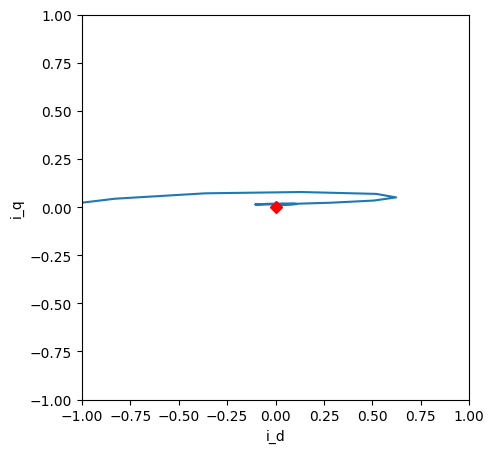

In [63]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(jnp.array(i_dqs)[:,0],jnp.array(i_dqs)[:,1]) #,label="currents"
ax.plot((obs_ref)[0],(obs_ref)[1],color="r",marker='D')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel("i_d")
ax.set_ylabel("i_q")

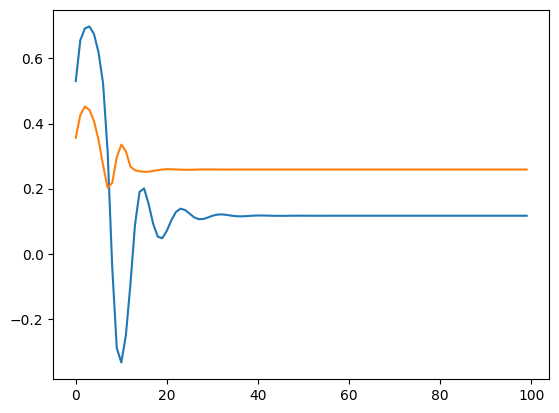

In [64]:
plt.plot(acts)

In [40]:
obs_ref[0]

Array(0.6940008, dtype=float32)

In [37]:
acts

[Array([-0.08222766, -0.06724966], dtype=float32),
 Array([-0.07949322, -0.07701714], dtype=float32),
 Array([-0.07026917, -0.11099883], dtype=float32),
 Array([-0.06045153, -0.15289561], dtype=float32),
 Array([-0.06313627, -0.19690032], dtype=float32),
 Array([-0.06614361, -0.24529807], dtype=float32),
 Array([-0.06968808, -0.3010579 ], dtype=float32),
 Array([-0.06893387, -0.3242161 ], dtype=float32),
 Array([-0.0666104 , -0.34821865], dtype=float32),
 Array([-0.06328493, -0.37507448], dtype=float32),
 Array([-0.05937209, -0.4062273 ], dtype=float32),
 Array([-0.05481713, -0.44354898], dtype=float32),
 Array([-0.04966681, -0.4858667 ], dtype=float32),
 Array([-0.0441948, -0.5324272], dtype=float32),
 Array([-0.03276188, -0.574994  ], dtype=float32),
 Array([-0.01380586, -0.61109555], dtype=float32),
 Array([ 0.00734436, -0.6446439 ], dtype=float32),
 Array([ 0.0281679, -0.6758555], dtype=float32),
 Array([ 0.04741172, -0.7046132 ], dtype=float32),
 Array([ 0.06513739, -0.7310187 ], 